In [1]:
import os.path
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import h5py
from datetime import datetime
from vb import *
import simulation
from sklearn.decomposition.factor_analysis import FactorAnalysis

In [2]:
## Prepare saving output
if not os.path.isdir('output'):
    os.mkdir('output')
dt = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
pp = PdfPages('output/{}.pdf'.format(dt))

In [3]:
## Parameters
T = 200
l = 1e-4
std = 2.0
p = 1.0

L = 2
N = 50
np.random.seed(0)

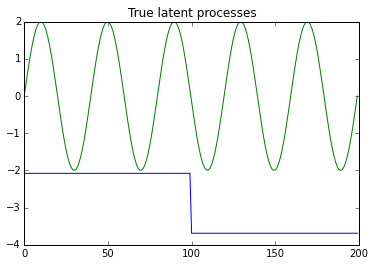

In [4]:
## Simulate a latent process
high = np.log(25.0/T)
low = np.log(5.0/T)

# simulate latent processes
x, ticks = simulation.latents(L, T, std, l)
x[:T//2, 0] = high
x[T//2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))

plt.figure()
plt.plot(x)
plt.title('True latent processes')

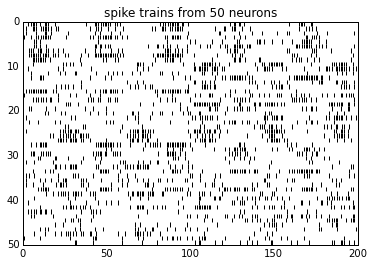

In [5]:
# simulate spike trains
# a = np.empty((L, N), dtype=float)
a = 2 * np.random.rand(L, N) - 1
a /= np.linalg.norm(a) / np.sqrt(N)

b = np.empty((1, N))
b[0, :] = high - np.sum(np.dot(a.T, x.T),1)/T
#b[0, :] = np.diag(np.dot(a.T, (a < 0) * -(high + low)))
y, Y, rate = simulation.spikes(x, a, b, intercept=True)

plt.figure()
plt.ylim(0, N)
for n in range(N):
    plt.vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
plt.title('spike trains from {} neurons'.format(N))
#plt.yticks(range(N))
plt.gca().invert_yaxis()
plt.tick_params(left="off",bottom="off",right="off",top="off")
plt.savefig(pp, format='pdf')

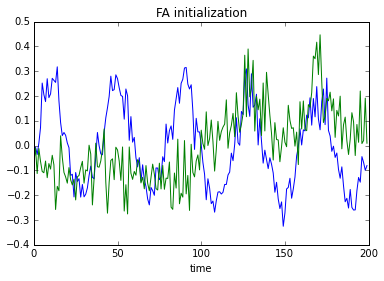

In [6]:
# Factor Analysis initialization
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

plt.figure()
plt.plot(m0)
plt.xlabel('time')
plt.title('FA initialization')
plt.savefig(pp, format='pdf')

In [7]:
## Setup GP prior for the latent processes
mu = np.zeros_like(x)
sigma = np.zeros((L, T, T))

cov = np.empty((T, T))
for i, j in itertools.product(range(T), range(T)):
    cov[i, j] = 2 * simulation.sqexp(i - j, 5e-3)
sigma[0, :, :] = cov + np.identity(T) * 1e-7

cov = np.empty((T, T))
for i, j in itertools.product(range(T), range(T)):
    cov[i, j] = 10 * simulation.sqexp(i - j, 1e-2)

sigma[1, :, :] = cov + np.identity(T) * 1e-7

In [8]:
## Inference for variational posterior over latents and maximization over other parameters
control = {'maxiter': 50,
           'fixed-point iteration': 3,
           'tol': 1e-3,
           'verbose': True}

m, V, a1, b1, a0, b0, lbound, elapsed, convergent = variational(y, 0, mu, sigma,
                                                                a0=a0,
                                                                b0=None,
                                                                m0=m0,
                                                                V0=sigma,
                                                                fixa=False, fixb=False, fixm=False, fixV=False,
                                                                anorm=np.sqrt(N), intercept=True,
                                                                constrain_m='', constrain_a='',
                                                                control=control)



Iteration[2]: L = -8743.38818, inc = 7086573.9776562396
delta alpha = 0.4747902111
delta beta = 0.0000000000
delta m = 0.3672127952
delta V = 9.9733716987

Iteration[3]: L = -7230.66901, inc = 1512.7191740764
delta alpha = 1.4985870690
delta beta = 0.0000000000
delta m = 1.1368615843
delta V = 0.0565120252

Iteration[4]: L = -7095.98912, inc = 134.6798830767
delta alpha = 2.4494580583
delta beta = 0.0000000000
delta m = 0.9900620461
delta V = 0.0217182761

Iteration[5]: L = -7020.44638, inc = 75.5427470951
delta alpha = 1.6066963257
delta beta = 0.0000000000
delta m = 0.0000000000
delta V = 0.0287042006

Iteration[6]: L = -6951.10223, inc = 69.3441428111
delta alpha = 0.9459542281
delta beta = 0.0000000000
delta m = 0.5958905995
delta V = 0.0544254923

Iteration[7]: L = -6949.08412, inc = 2.0181154078
delta alpha = 0.2540970222
delta beta = 0.0000000000
delta m = 0.0000000000
delta V = 0.0021346493

Iteration[8]: L = -6930.33422, inc = 18.7498972358
delta alpha = 0.7176024038
delta be

In [10]:
## Save results
it = len(lbound)
log = h5py.File('output/{}.hdf5'.format(dt), 'a')
log.create_dataset(name='iteration', data=it)
log.create_dataset(name='convergence', data=convergent)
log.create_dataset(name='time', data=elapsed)
log.create_dataset(name='lower bounds', data=lbound)
log.create_dataset(name='smoothness', data=l)
log.create_dataset(name='prior mean', data=mu)
log.create_dataset(name='prior covariance', data=sigma)
log.create_dataset(name='true beta', data=b)
log.create_dataset(name='true alpha', data=a)
log.create_dataset(name='spike', data=y)
log.create_dataset(name='latent', data=x)
log.create_dataset(name='initial alpha', data=a0)
log.create_dataset(name='initial beta', data=b0)
log.create_dataset(name='posterior mean', data=m)
log.create_dataset(name='posterior covariance', data=V)
log.create_dataset(name='estimated alpha', data=a1)
log.create_dataset(name='estimated beta', data=b1)
log.close()

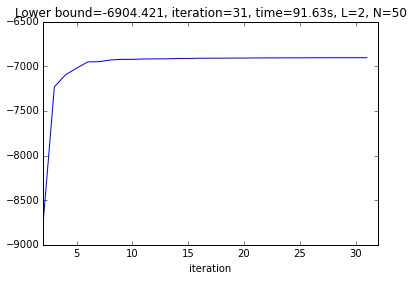

In [11]:
# plot lowerbound
plt.figure()
frm = 1
plt.plot(range(frm + 1, it + 1), lbound[frm:])
#plt.yticks([])
plt.xlim([frm + 1, it + 1])
plt.xlabel('iteration')
plt.title('Lower bound={:.3f}, iteration={:d}, time={:.2f}s, L={:d}, N={:d}'.format(lbound[it-1], it, elapsed, L, N))
plt.savefig(pp, format='pdf')

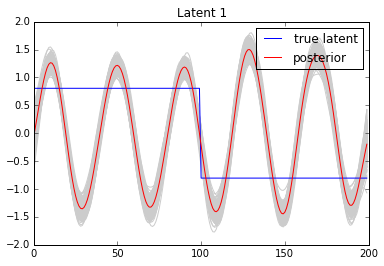

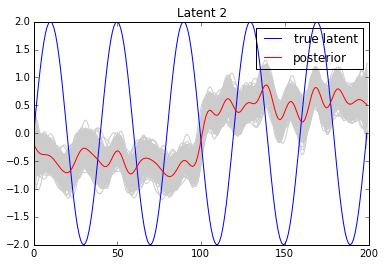

In [12]:
# plot latent
ns = 500
for l in range(L):
    plt.figure()
    z = np.random.randn(T, ns)
    lt = np.linalg.cholesky(V[l, :, :])
    s = np.dot(lt, z)
    for n in range(ns):
        plt.plot(s[:, n] + m[:, l], color='0.8')
    plt.plot(x[:, l] - np.mean(x[:, l]), label='true latent', color='blue')
    plt.plot(m[:, l], label='posterior', color='red')
    plt.legend()
    plt.title('Latent {}'.format(l + 1))
    plt.savefig(pp, format='pdf')

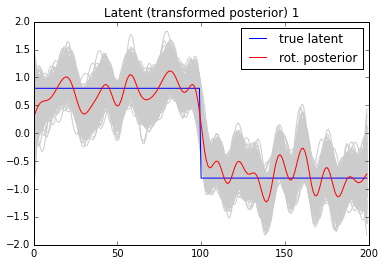

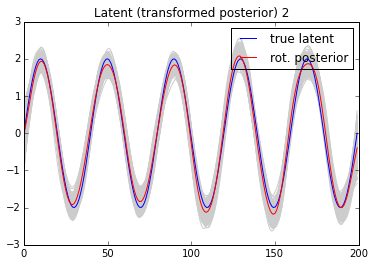

In [13]:
## Rotate latents to match the true
c = np.linalg.lstsq(m, x)[0]
m2 = np.dot(m, c)
ns = 500
z = np.random.randn(ns, T, L)
for l in range(L):
    z[:, :, l] = np.dot(np.linalg.cholesky(V[l, :, :]), z[:, :, l].T).T + m[:, l]
for l in range(L):
    plt.figure()
    for n in range(ns):
        plt.plot(np.dot(z[n, :, :], c)[:, l], color='0.8')
    plt.plot(x[:, l] - np.mean(x[:, l]), label='true latent', color='blue')
    plt.plot(m2[:, l], label='rot. posterior', color='red')
    plt.legend()
    plt.title('Latent (transformed posterior) {}'.format(l + 1))
    plt.savefig(pp, format='pdf')

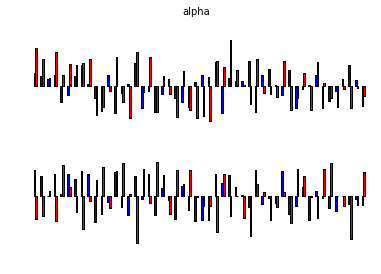

In [14]:
## Plot inferred loadings matrix
_, ax = plt.subplots(L, sharex=True)
if L == 1:
    ax = [ax]
for l in range(L):
    ax[l].bar(np.arange(N), a[l, :], width=0.25, color='blue', label='true')
    ax[l].bar(np.arange(N) + 0.25, a1[l, :], width=0.25, color='red', label='estimate')
    ax[l].axis('off')
plt.suptitle('alpha')
plt.savefig(pp, format='pdf')

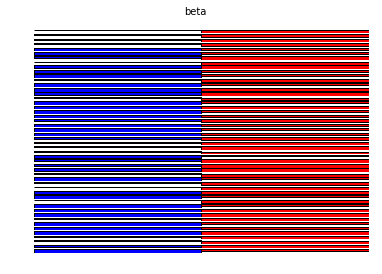

In [15]:
## plot inferred bias and autoregressive terms
_, ax = plt.subplots(N, sharex=True)
for n in range(N):
    ax[n].bar(np.arange(b.shape[0]), b[:, n], width=0.25, color='blue', label='true')
    ax[n].bar(np.arange(b.shape[0]) + 0.25, b1[:, n], width=0.25, color='red', label='estimate')
    ax[n].axis('off')
plt.suptitle('beta')
plt.savefig(pp, format='pdf')

In [16]:
pp.close()